## Working over Point Clouds with Graph Neural Networks
In this laboratory, we will learn how to handle point cloud data with graph neural networks. Point clouds are unsorted sets of points in the space. Each point has a feature set of that consists of its spatial location.

Once again let's begin by making sure the software dependencies are available in our machine:

In [6]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.0+cu121


### Point Cloud Visualization
Lets create a simple routine to visualize our point clouds. The function visualize_mesh will be used to render the initial data points we obtain from the built-in pytorch-geometric dataset. visualize_points will be useful to visualize our pointcloud, which is the very same data but with the node connectivity removed.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

Remember we want to embed those point cloud objects in such a way so that they are linearly separable given a task at hand (Classification for this laboratory).  The initial input is the point cloud data and the Gpah Neural Network and will learn to group and process the features on the data. Namely spatial features.

We will be using the utility function torch_geometric.transforms.SamplePoints transformation, which will uniformly sample a fixed number of points on the mesh faces according to their face area.

Lets load the point data from the pytorch geometric library.

Extracting data/GeometricShapes/raw.zip
Processing...


Data(pos=[300, 3], y=[1])


Done!


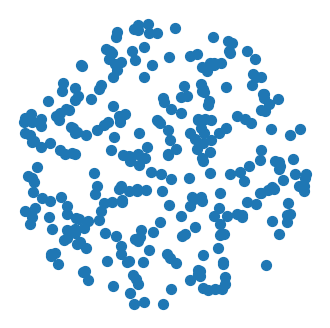

Data(pos=[300, 3], y=[1])


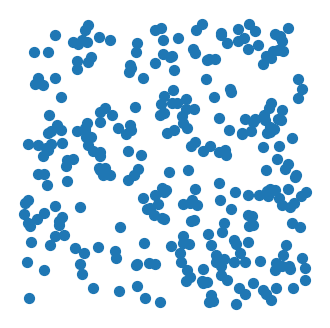

Data(pos=[300, 3], y=[1])


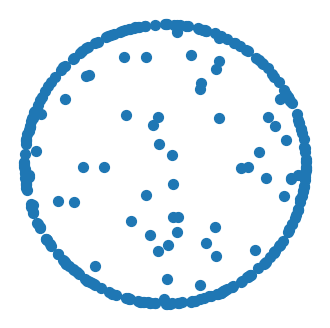

Data(pos=[300, 3], y=[1])


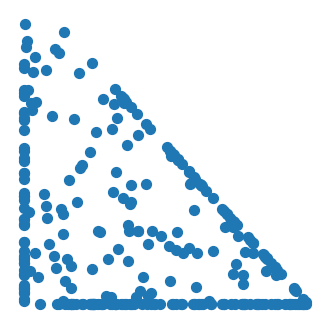

tensor([[-0.5685, -0.4000, -0.4739],
        [-0.8000, -0.0625,  0.0796],
        [-0.8001,  0.4273,  0.5408],
        [ 1.1044, -0.3043, -0.6518],
        [ 0.3593,  0.4406, -0.4299],
        [-0.7999, -0.3018, -0.7689],
        [-0.7999, -0.3076,  0.1704],
        [-0.1050,  0.9048, -0.2930],
        [-0.5751, -0.1715, -0.8858],
        [-0.8000, -0.0102, -0.3681],
        [-0.5223,  1.3220, -0.0947],
        [-0.8001,  0.5076,  0.0218],
        [ 0.9892, -0.4000, -0.4660],
        [ 0.0321, -0.4000, -0.7227],
        [ 0.2309,  0.5689,  0.4823],
        [ 0.9837, -0.1837, -0.7692],
        [ 0.3203, -0.0747,  0.8373],
        [ 0.6764,  0.1236,  0.2292],
        [ 0.6530,  0.1469,  0.0071],
        [ 1.1692, -0.3691, -0.7817],
        [ 1.0131, -0.2131, -0.3515],
        [ 0.5341, -0.0647, -0.8324],
        [ 0.3687,  0.3622, -0.6189],
        [-0.8002,  1.0962, -0.1455],
        [-0.1138, -0.4000,  0.4494],
        [-0.0952,  0.8700,  0.3650],
        [-0.4665, -0.4000,  0.0483],
 

In [4]:
import torch
from torch_geometric.transforms import SamplePoints
from torch_geometric.datasets import GeometricShapes

torch.manual_seed(42)

dataset = GeometricShapes(root='data/GeometricShapes')

dataset.transform = SamplePoints(num=300)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
visualize_points(data.pos)

data = dataset[15]
print(data)
visualize_points(data.pos)

data = dataset[30]
print(data)
visualize_points(data.pos)
print(data.pos)

## Building Point-Net++

PointNet++ processes point clouds iteratively by first grouping the points into local neighborhoods. Then, it aggregates features from each neighborhood and down-samples the point cloud. This process is repeated until the desired level of detail is achieved. We will not be downsampling,  but increasing the number of layers we will accumulate features of larger neighborhoods.

## Graph Generation
Before we proceed with any message passing, we need to build some node connectivity in the point clouds.. We can use the function knn_graph from torch_cluster and call it by passing in the input points pos and the number of nearest neighbors k. As output, we will receive an edge_index tensor of shape [2,num_edges].
Notice how k becomes a hyper parameter

torch.Size([2, 600])


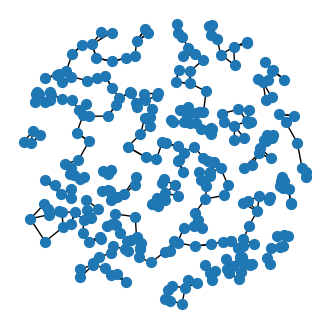

torch.Size([2, 1800])


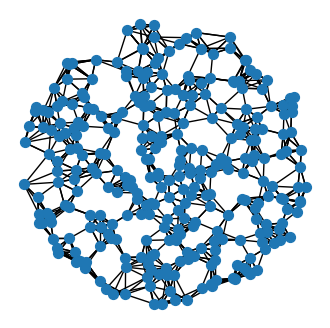

torch.Size([2, 3000])


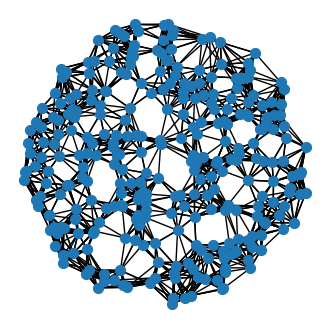

torch.Size([2, 600])


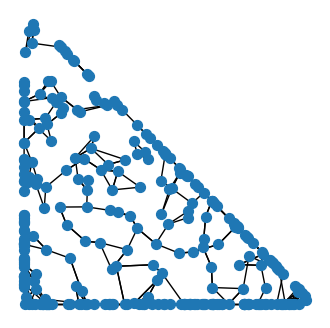

torch.Size([2, 1800])


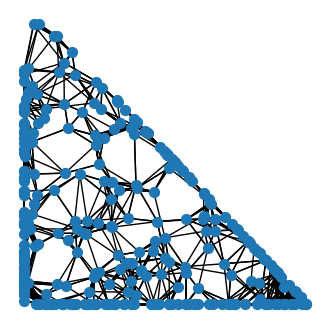

torch.Size([2, 3000])


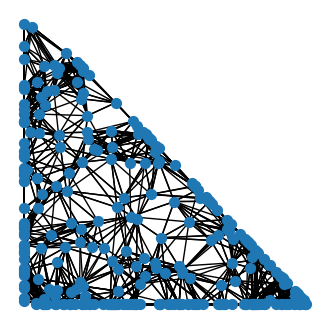

Data(pos=[300, 3], y=[1], edge_index=[2, 3000])


In [7]:
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=2)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=10)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[30]
data.edge_index = knn_graph(data.pos, k=2)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[30]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[30]
data.edge_index = knn_graph(data.pos, k=10)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

print(data)

Let's define a simple point net network. The PointNet++ uses the edge-convoultion to create a graph neural Network. Remember that one from our first classes?.

$$
\mathbf{h}^{(\ell + 1)}_i = \max_{j \in \mathcal{N}(i)} \textrm{MLP} \left( \mathbf{h}_j^{(\ell)}, \mathbf{p}_j - \mathbf{p}_i \right)
$$
where
* $\mathbf{h}_i^{(\ell)} \in \mathbb{R}^d$ denotes the hidden features of point $i$ in layer $\ell$
* $\mathbf{p}_i \in \mathbb{R}^3$ denotes the position of point $i$.

For the sake of this lab lets define the edge-convoultion layer:

In [8]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing

class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(?, out_channels))

    def forward(self, h, pos, edge_index):
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

Now that we have a connected graph , a suitable convolutional layer and a network. We can start building a Graph neural Network that will predict the shape we are looking at. We will include two point net layers and a classifier layer.

In [9]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(?, 32)
        self.conv2 = PointNetLayer(?, 32)
        self.classifier = Linear(?, ?)

    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)

        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]

        # 5. Classifier.
        return ?


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer()
  (conv2): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [10]:
from torch_geometric.loader import DataLoader

train_dataset = GeometricShapes(root='data/GeometricShapes', train=?,
                                transform=SamplePoints(128))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=?,
                               transform=SamplePoints(128))


# use batch_size 10
train_loader = ?
test_loader = ?

model = ?
optimizer = ?
criterion = ?  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()

    total_loss = 0
    for data in loader:
        ? # Clear gradients.
        ? = model(?, data.batch)  # Forward pass.
        ? = criterion(?, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = ?
        pred = logits.?(dim=-1)
        total_correct += int((pred ? data.y).?())

    return total_correct / len(loader.dataset)

for epoch in range(?):
    loss = train(?)
    test_acc = test(?)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch: 00, Loss: 3.7553, Test Accuracy: 0.0500
Epoch: 01, Loss: 3.7000, Test Accuracy: 0.0500
Epoch: 02, Loss: 3.6860, Test Accuracy: 0.0750
Epoch: 03, Loss: 3.6659, Test Accuracy: 0.0500
Epoch: 04, Loss: 3.6388, Test Accuracy: 0.0250
Epoch: 05, Loss: 3.5740, Test Accuracy: 0.0250
Epoch: 06, Loss: 3.5125, Test Accuracy: 0.0250
Epoch: 07, Loss: 3.4458, Test Accuracy: 0.0250
Epoch: 08, Loss: 3.4267, Test Accuracy: 0.0500
Epoch: 09, Loss: 3.3394, Test Accuracy: 0.1250
Epoch: 10, Loss: 3.2901, Test Accuracy: 0.1000
Epoch: 11, Loss: 3.2211, Test Accuracy: 0.1250
Epoch: 12, Loss: 3.1483, Test Accuracy: 0.1250
Epoch: 13, Loss: 3.0825, Test Accuracy: 0.2000
Epoch: 14, Loss: 2.9765, Test Accuracy: 0.2750
Epoch: 15, Loss: 2.8798, Test Accuracy: 0.2500
Epoch: 16, Loss: 2.7901, Test Accuracy: 0.2500
Epoch: 17, Loss: 2.6688, Test Accuracy: 0.3000
Epoch: 18, Loss: 2.4352, Test Accuracy: 0.3500
Epoch: 19, Loss: 2.4404, Test Accuracy: 0.3750
Epoch: 20, Loss: 2.3098, Test Accuracy: 0.4500
Epoch: 21, Lo

85 percent accuracy is very good, but try to see if  you improve this results with a deeper network and a large number of epochs